In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# library with functions from Part 1
from classification_utils import *

# Model calibration

This section is all about estimating the **score function**
$$\boxed{f(x) = \mathbb P (Y=1|X=x)}$$

which, as we know, really generates everything in binary classification. This is our main object of interest.

Recall that in the first chapter we discussed how one can obtain binary predictions from a score $f$ by choosing a threshold $\lambda$:

$$\hat{y}(x) = \begin{cases}
1 & \mbox{if } f(x) \geq \lambda \\
0 & \mbox{if } f(x) < \lambda
\end{cases}
$$

Now, forget that we know that $f$ is a probability and let us take the definition of $\hat y(x)$ above as-is, for any real-valued function $f$. It still makes sense: for big values of $f(x)$ it spits out a 1, and for small values it returns a 0. 

In fact, **most machine learning algorithms don't estimate the score** $\mathbb P (Y=1|X=x)$. They just calculate a new function, say $\hat f$, from which one can create rules exactly like before:

$$\begin{cases}
1 & \mbox{if } \hat f(x) \geq \lambda \\
0 & \mbox{if } \hat f(x) < \lambda
\end{cases}
$$

In fact, $\hat f$ does not even need to be bound to $[0,1]$ (but we can suppose it is, with no loss of generality; were it not, we would just need to normalize it).

**Is $\hat f$ a probability?** No, not necessarily. But why?

### When scores are not probabilities

For some arbitrary random variable $Z$, What does $\mathbb P (Z<40) = 0.2$ mean?

An interesting way to characterize this is via simulation. Let $Z_1, Z_2, \ldots, Z_n$ be $n$ iid copies of $Z$. If we measure all the $Z_i$'s, and build a histogram, what the statement $\mathbb P (Z<40) = 0.2$ really means is that *about 20% of the samples will have values lesser than 40*.

**This same reasoning can be applied to the score function**. 

Let's start with our favorite dataset as before:

In [2]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(n_samples=5000, n_features=10, n_informative=8, n_redundant=1, n_repeated=1, 
                           random_state=10)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

We will train 3 different models: gradient boosted trees, random forest, and a good old logistic regression.

In [3]:
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [4]:
gb = HistGradientBoostingClassifier(max_depth=5, random_state=1)
rf = RandomForestClassifier(max_depth=5, random_state=2)
lr = LogisticRegression()

In [19]:
gb.fit(X_train, y_train);
rf.fit(X_train, y_train);
lr.fit(X_train, y_train);

For each of the models, let's plot their test set performances (using the functions we developed in the first part)

**Gradient boosting**

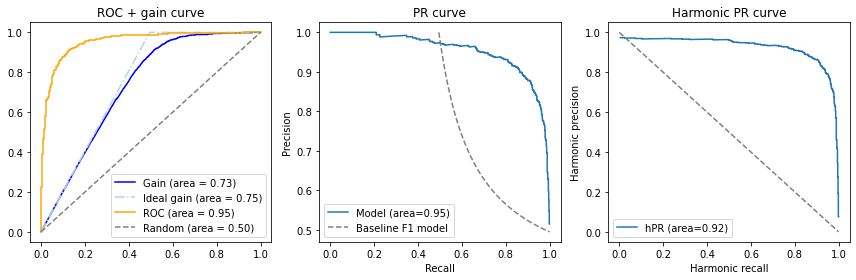

In [6]:
roc_pr_hpr_report(y_test,
                 gb.predict_proba(X_test)[:,1]
                 )

**Random forest**

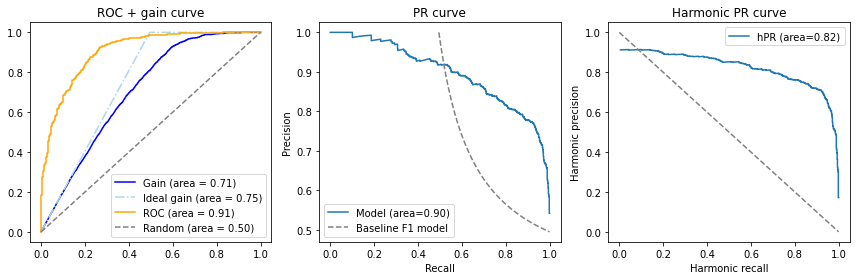

In [7]:
roc_pr_hpr_report(y_test,
                 rf.predict_proba(X_test)[:,1]
                 )

**Logistic regression**

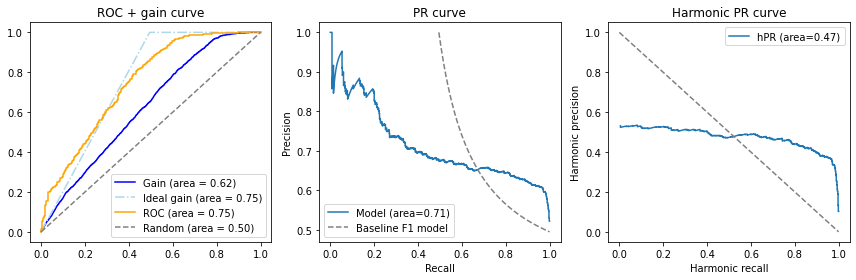

In [8]:
roc_pr_hpr_report(y_test,
                 lr.predict_proba(X_test)[:,1]
                 )

We can also just write the results into a table:

|Model|AUC|AP|AUhPR|
|---|---|---|---|
|Logistic regression|0.75|0.71|0.47|
|Random forest|0.91|0.90|0.82|
|Gradient boosting|0.95|0.95|0.92|

We see that the gradient boosted model outperforms the other two in all three metrics.

The question is, how do these models compare regarding how well they predict actual probabilities? 

Let's take the logistic regression model as an example. We predict its scores for all elements in the test set, and sort our data from low to high scores:

In [9]:
y_probs = lr.predict_proba(X_test)[:,1]

In [10]:
predictions = pd.DataFrame({
    'label': y_test,
    'scores': y_probs,
})

In [20]:
predictions.head()

,label,scores
0,0,0.059244
1,0,0.214240
2,1,0.749504
3,1,0.635831
4,0,0.252864


There are two strategies we can follow in order to compare predicted vs. actual probabilities:
1. **Quantile strategy**: take your data (the DataFrame above) and split it into $n$ equally sized chunks based on the list of scores. In each chunk, you'll have an average of the predicted scores (say, 80%) as well as an average of how many times one had $y=1$ inside that chunk. A well-calibrated model would have this latter frequency equal to 80% as well

2. **Uniform strategy**: instead of splitting into equally sized chunks, we consider a sequence of fixed scores (eg, 10%, 20%, 30%...) and break the data into bins between each of these scores. Again, in each chunk, you'll have an average of the predicted scores as well as an average of how many times one had $y=1$ inside that chunk. 

From this reasoning, we could build a curve where, one one axis, we plot the average score inside each chunk, and on the other axis, we plot the average number of defaults observed.

The function below does both, for each of the strategies:

In [12]:
def calib_curve(y_true, y_probs, n_bins=10, method='quantile'):
    
    assert method in ['quantile', 'uniform'], "Unrecognized method"
    
    predictions = pd.DataFrame({
        'label': y_true,
        'scores': y_probs,
        })
    
    predictions = predictions.sort_values('scores')
    
    if method == 'quantile':
        quantiles = [predictions['scores'].quantile(q) for q in np.linspace(0, 1, n_bins+1)] 
        predictions['bins'] = pd.cut(predictions['scores'], quantiles)

    else:
        bins=np.linspace(0, 1, n_bins+1) 
        predictions['bins'] = pd.cut(predictions['scores'], bins)
        
    # we can now aggregate: average y=1 per chunk and average score per chunk
    calibration = predictions.groupby('bins').mean().reset_index(drop=True)
    calibration.columns = ['Fraction of positives', 'Average score']
    
    return calibration

Let's use both methods and compare to the `sklearn` native method:

In [13]:
n_bins = 10  # split into 10 chunks

In [14]:
quantile_calibration = calib_curve(y_test, y_probs, n_bins=n_bins, method='quantile')
uniform_calibration = calib_curve(y_test, y_probs, n_bins=n_bins, method='uniform')

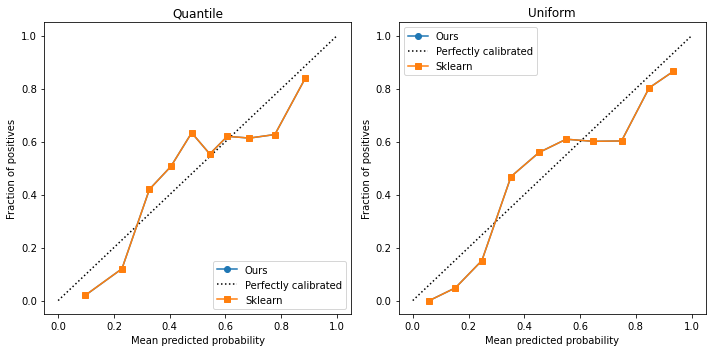

In [15]:
from sklearn.calibration import CalibrationDisplay

fig, ax = plt.subplots(ncols=2, figsize=(10,5))

# Quantile calibration
ax[0].plot(quantile_calibration["Average score"], quantile_calibration["Fraction of positives"], label='Ours', marker='o')
CalibrationDisplay.from_predictions(y_test,
                                   y_probs,
                                   n_bins=n_bins,
                                   ax=ax[0],
                                   name='Sklearn',
                                   strategy='quantile')

# Uniform calibration
ax[1].plot(uniform_calibration["Average score"], uniform_calibration["Fraction of positives"], label='Ours', marker='o')
CalibrationDisplay.from_predictions(y_test,
                                   y_probs,
                                   n_bins=n_bins,
                                   ax=ax[1],
                                   name='Sklearn',
                                   strategy='uniform')

ax[0].set_title("Quantile")
ax[1].set_title("Uniform")
plt.legend()
plt.tight_layout()
plt.show()

As we can see, our curves are identical. Scikit-learn uses the same logic to build their curves. We can happily use their library.

### How to interpret a calibration curve?

Consider the plot on the right, for simplicity, and look at the y axis. 
* For small pobabilities (until around 0.25), our model is too "optimistic": it outputs higher scores than it should
* This behavior is the same for high probabilities (above 0.60)
* It is opposite for intermediate probabilities (between 0.3 and 0.6), for which the model is actually pessimistic: the predicted scores are smaller than the corresponding probabilities

### How to choose the number of bins?

There is a trade-off here:
* The estimated probability is calculated as the fraction of positives per bin. If the bin number is too high, this means each bin has fewer entries and this estimated probability gets more biased. You'll have a noiser curve.
* If the number of bins is too small, there might not be enough information to assess the calibration curve

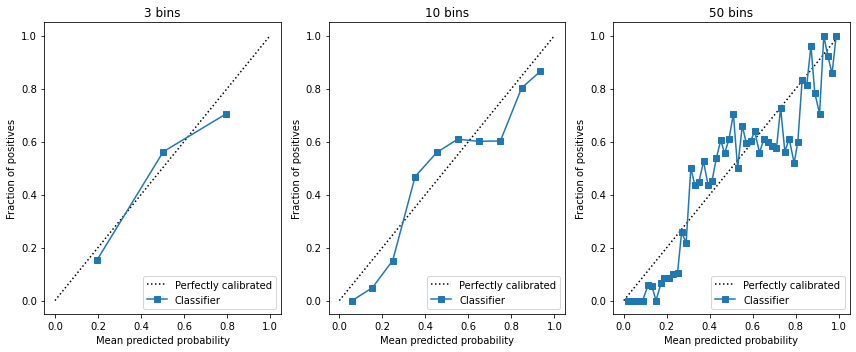

In [16]:
fig, ax = plt.subplots(ncols=3, figsize=(12,5))
for n, axx in zip([3, 10, 50], ax):
    CalibrationDisplay.from_predictions(y_test,
                                       y_probs,
                                       n_bins=n,
                                       ax=axx,
                                       strategy='uniform')
    axx.set_title(f"{n} bins")
    
plt.tight_layout()
plt.show()

Usually, 5-10 bins work just fine.

### Does calibration affect performance?

TODO: write this one

## Calibrating a model

Let's see the calibration curves for our 3 models:

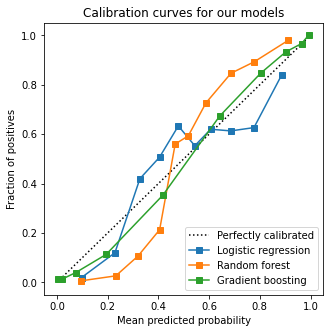

In [17]:
fig, ax = plt.subplots(figsize=(5,5))
for model, name in zip([lr, rf, gb], ["Logistic regression", "Random forest", "Gradient boosting"]):
    CalibrationDisplay.from_predictions(y_test,
                                       model.predict_proba(X_test)[:,1],
                                       n_bins=10,
                                       name=name,
                                       ax=ax,
                                       strategy='quantile')
    
ax.set_title("Calibration curves for our models")
plt.show()

We see that for our models, gradient boosting is actually the better calibrated one (besides having the best performances).

There are two ways to calibrate a model:
1. Take a pre-trained model and use a 1-1 function to "scale up and down" its outputs, so that it better reflects the inherent probabilities.
2. Train both model and the "calibrator" together from the beginning.

In [21]:
from sklearn.calibration import CalibratedClassifierCV

In [ ]:
calibrator = CalibratedClassifierCV(base_estimator=lr, cv='prefit', method='isotonic')

clf.fit(X_train, y_train)
display = CalibrationDisplay.from_estimator(
    clf,b
    
    X_test,
    y_test,
    n_bins=10,
    name=name,
    ax=ax_calibration_curve,
    color=colors(i),
)

TODO: write this section